# Proyek Klasifikasi Gambar: Cat & Dogs
- **Nama:** Faiz Muhamad Al Ghifari
- **Email:** m297d5y0575@student.devacademy.id
- **ID Dicoding:** m297d5y0575

## Import Semua Packages/Library yang Digunakan

In [39]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflowjs as tfjs
import pathlib

from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from pathlib import Path
from google.colab import files

## Data Preparation

### Data Loading

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"faizunn","key":"9c7018138213f603de9a6ea2e6da5cc6"}'}

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d d4rklucif3r/cat-and-dogs
!unzip cat-and-dogs.zip

Dataset URL: https://www.kaggle.com/datasets/d4rklucif3r/cat-and-dogs
License(s): DbCL-1.0
cat-and-dogs.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  cat-and-dogs.zip
replace dataset/single_prediction/cat_or_dog_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


### Data Preprocessing

#### Split Dataset

In [6]:
train_dir = "/content/dataset/training_set"
test_dir = "/content/dataset/test_set"

combined_dir = "/content/cat_and_dogs/dataset"

In [7]:
os.makedirs(combined_dir, exist_ok=True)

In [8]:
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

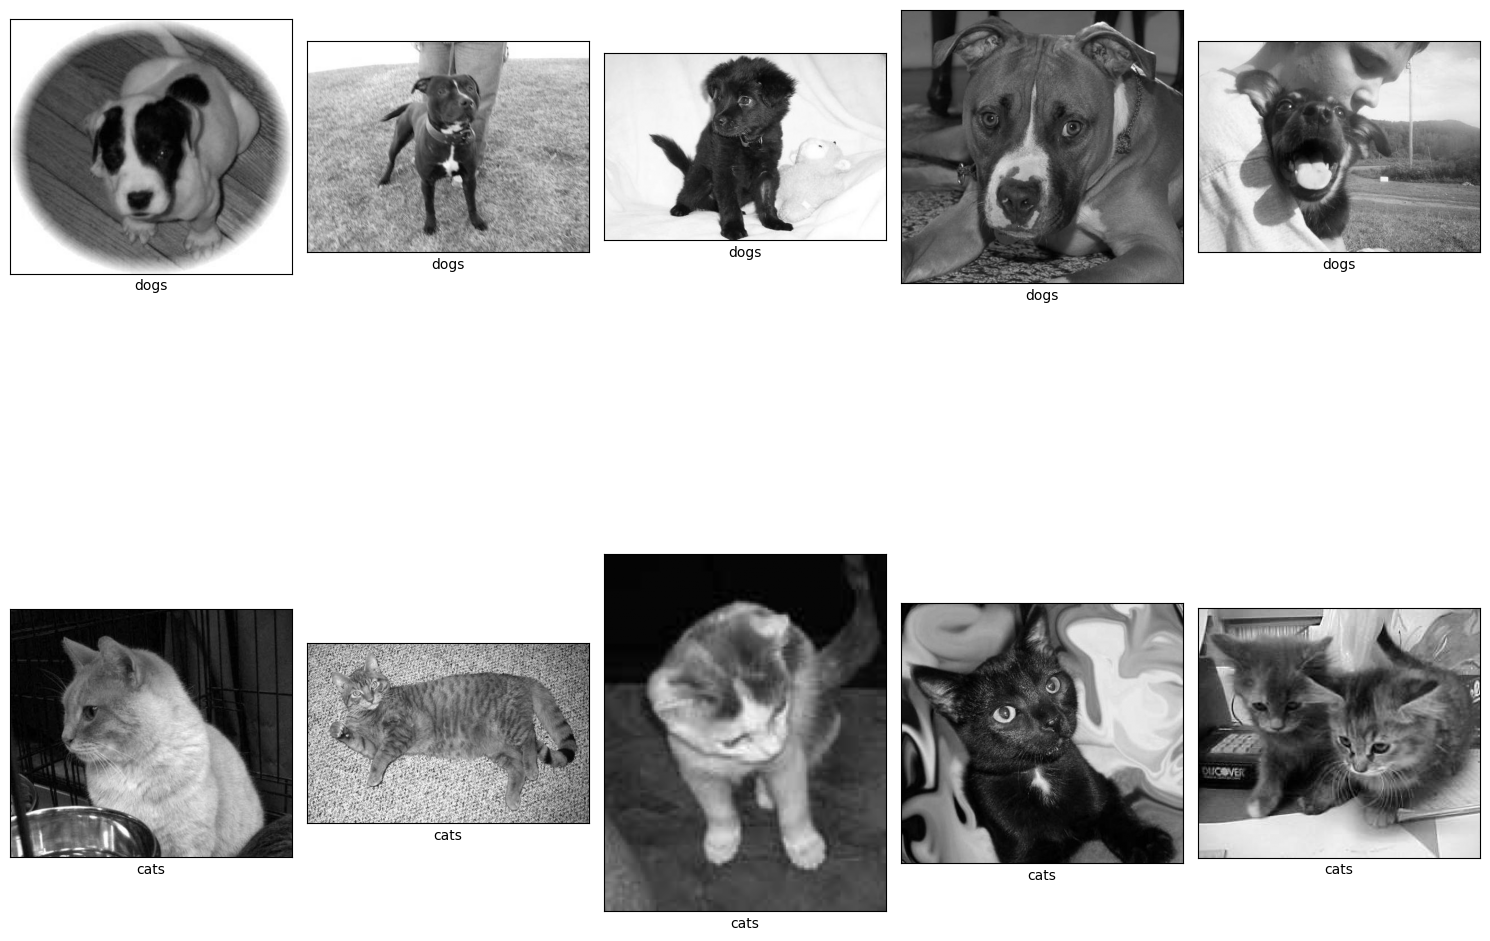

In [9]:
animal_image = {}

path = "cat_and_dogs/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    animal_image[i] = os.listdir(os.path.join(path_sub, i))

path_sub = "cat_and_dogs/dataset/"

fig, axs = plt.subplots(len(animal_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(animal_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

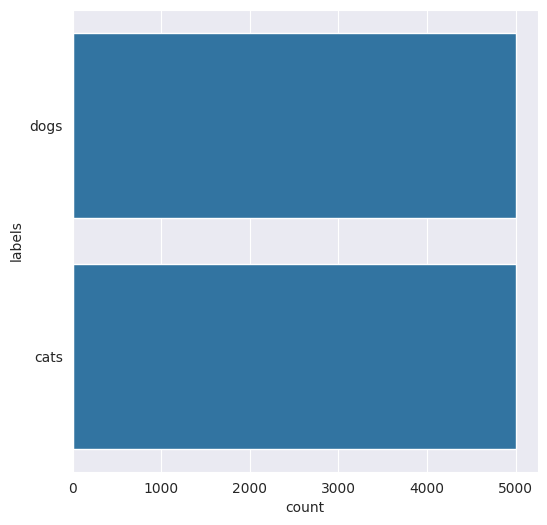

In [10]:
animal_path = "cat_and_dogs/dataset/"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(animal_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [11]:
mypath= 'cat_and_dogs/dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
df.groupby(['labels']).size()

,0
labels,
cats,5000
dogs,5000


In [12]:
X= df['path']
y= df['labels']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [13]:
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [14]:
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print('Distribusi Data:')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print(f'Total data: {len(df_all)}')
print('===================================================== \n')

print('Proporsi Data:')
print(df_all['set'].value_counts(normalize=True))
print('\n===================================================== \n')

print('Sampel Data:')
print(df_all.sample(5))
print('\n===================================================== \n')

datasource_path = "cat_and_dogs/dataset/"
dataset_path = "Dataset-Final/"


Distribusi Data:
set    labels
test   cats      1010
       dogs       990
train  cats      3990
       dogs      4010
dtype: int64 

Total data: 10000

Proporsi Data:
set
train    0.8
test     0.2
Name: proportion, dtype: float64


Sampel Data:
                                        path labels    set
9368  cat_and_dogs/dataset/dogs/dog.3751.jpg   dogs   test
8503  cat_and_dogs/dataset/dogs/dog.2884.jpg   dogs   test
8209  cat_and_dogs/dataset/cats/cat.1541.jpg   cats   test
5507   cat_and_dogs/dataset/dogs/dog.811.jpg   dogs  train
1898  cat_and_dogs/dataset/cats/cat.3842.jpg   cats  train




In [15]:
for index, row in tqdm(df_all.iterrows(), total=len(df_all), desc="Memproses file"):
    file_path = row['path']
    if os.path.exists(file_path) == False:
        file_path = os.path.join(datasource_path, row['labels'], row['path'].split('/')[-1])

    if not os.path.exists(file_path):
        print(f"Warning: File tidak ditemukan - {file_path}")
        continue

    dest_dir = os.path.join(dataset_path, row['set'], row['labels'])
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir, exist_ok=True)

    destination_file_name = os.path.basename(file_path)
    file_dest = os.path.join(dest_dir, destination_file_name)

    if not os.path.exists(file_dest):
        shutil.copy2(file_path, file_dest)
    else:
        print(f"File sudah ada: {file_dest}")

print('\n=====================================================')
print('Proses pembagian dataset selesai!')
print(f'Data training: {len(df_tr)} sampel')
print(f'Data testing: {len(df_te)} sampel')
print('=====================================================')

Memproses file:   0%|          | 0/10000 [00:00<?, ?it/s]

Output streaming akan dipotong hingga 5000 baris terakhir.
File sudah ada: Dataset-Final/train/dogs/dog.3930.jpg
File sudah ada: Dataset-Final/train/cats/cat.3420.jpg
File sudah ada: Dataset-Final/train/cats/cat.4799.jpg
File sudah ada: Dataset-Final/train/cats/cat.1815.jpg
File sudah ada: Dataset-Final/train/dogs/dog.364.jpg
File sudah ada: Dataset-Final/train/dogs/dog.2640.jpg
File sudah ada: Dataset-Final/train/cats/cat.2905.jpg
File sudah ada: Dataset-Final/train/dogs/dog.4605.jpg
File sudah ada: Dataset-Final/train/cats/cat.2089.jpg
File sudah ada: Dataset-Final/train/cats/cat.3073.jpg
File sudah ada: Dataset-Final/train/dogs/dog.3932.jpg
File sudah ada: Dataset-Final/train/cats/cat.1403.jpg
File sudah ada: Dataset-Final/train/cats/cat.1122.jpg
File sudah ada: Dataset-Final/train/cats/cat.1109.jpg
File sudah ada: Dataset-Final/train/dogs/dog.3954.jpg
File sudah ada: Dataset-Final/train/dogs/dog.3394.jpg
File sudah ada: Dataset-Final/train/dogs/dog.881.jpg
File sudah ada: Dataset-F

In [16]:
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_cat = os.path.join(TRAIN_DIR + '/cats')
train_dog = os.path.join(TRAIN_DIR + '/dogs')
test_cat = os.path.join(TEST_DIR + '/cats')
test_dog = os.path.join(TEST_DIR + '/dogs')

print("Total number of cat images in training set: ",len(os.listdir(train_cat)))
print("Total number of dog images in training set: ",len(os.listdir(train_dog)))
print("Total number of cat images in test set: ",len(os.listdir(test_cat)))
print("Total number of dog images in test set: ",len(os.listdir(test_dog)))

Total number of cat images in training set:  3990
Total number of dog images in training set:  4010
Total number of cat images in test set:  1010
Total number of dog images in test set:  990


In [22]:
# Buat objek ImageDataGenerator yang menormalkan gambar
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="rgb",
                                              class_mode='binary',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                color_mode="rgb",
                                                   class_mode='binary',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="rgb",
                                                  class_mode='binary',
                                                  shuffle=False)

Found 6400 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Modelling

In [23]:
tf.keras.backend.clear_session()

base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

base_model.trainable = False

model_1 = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
    ])

model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

print(model_1.summary())

/tmp/ipython-input-1132154840.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,048,513 (11.63 MB)

 Trainable params: 788,993 (3.01 MB)

 Non-trainable params: 2,259,520 (8.62 MB)

None


In [24]:
count_cat, count_dog = len(os.listdir(train_cat)), len(os.listdir(train_dog))
weight_0 = (1 / count_cat) * (count_cat + count_dog) / 2.0
weight_1 = (1 / count_dog) * (count_dog + count_cat) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}

%time

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

callbacks = [early_stopping, reduce_lr, checkpoint]

history = model_1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    callbacks=callbacks,
    verbose=1
)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.9106 - loss: 0.2090

200/200 ━━━━━━━━━━━━━━━━━━━━ 182s 870ms/step - accuracy: 0.9107 - loss: 0.2088 - val_accuracy: 0.9494 - val_loss: 0.1516 - learning_rate: 0.0010
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.9549 - loss: 0.1145

200/200 ━━━━━━━━━━━━━━━━━━━━ 178s 890ms/step - accuracy: 0.9548 - loss: 0.1145 - val_accuracy: 0.9606 - val_loss: 0.0983 - learning_rate: 0.0010
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.9609 - loss: 0.0975

200/200 ━━━━━━━━━━━━━━━━━━━━ 162s 810ms/step - accuracy: 0.9609 - loss: 0.0976 - val_accuracy: 0.9613 - val_loss: 0.0926 - learning_rate: 0.0010
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 162s 812ms/step - accuracy: 0.9691 - loss: 0.0794 - val_accuracy: 0.9613 - val_loss: 0.0940 - learning_rate: 0.0010
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 210s 854ms/step - accuracy: 0.9716 - loss: 0.0725 - val_accuracy: 0.9575 - val_loss: 0.0984 - learning_rate: 0.0010
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 167s 834ms/step - accuracy: 0.9754 - loss: 0.0726 - val_accuracy: 0.9563 - val_loss: 0.1120 - learning_rate: 0.0010
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.9743 - loss: 0.0666

200/200 ━━━━━━━━━━━━━━━━━━━━ 201s 830ms/step - accuracy: 0.9743 - loss: 0.0666 - val_accuracy: 0.9619 - val_loss: 0.1035 - learning_rate: 0.0010
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.9772 - loss: 0.0587

200/200 ━━━━━━━━━━━━━━━━━━━━ 167s 832ms/step - accuracy: 0.9772 - loss: 0.0587 - val_accuracy: 0.9656 - val_loss: 0.1042 - learning_rate: 0.0010
Epoch 9/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 170s 848ms/step - accuracy: 0.9817 - loss: 0.0489 - val_accuracy: 0.9638 - val_loss: 0.1035 - learning_rate: 2.0000e-04
Epoch 10/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 207s 876ms/step - accuracy: 0.9850 - loss: 0.0480 - val_accuracy: 0.9619 - val_loss: 0.1032 - learning_rate: 2.0000e-04
Epoch 11/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 191s 821ms/step - accuracy: 0.9874 - loss: 0.0361 - val_accuracy: 0.9644 - val_loss: 0.1019 - learning_rate: 2.0000e-04
Epoch 12/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 167s 835ms/step - accuracy: 0.9851 - loss: 0.0380 - val_accuracy: 0.9613 - val_loss: 0.1041 - learning_rate: 2.0000e-04
Epoch 13/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 166s 831ms/step - accuracy: 0.9870 - loss: 0.0395 - val_accuracy: 0.9638 - val_loss: 0.1069 - learning_rate: 2.0000e-04


## Evaluasi dan Visualisasi

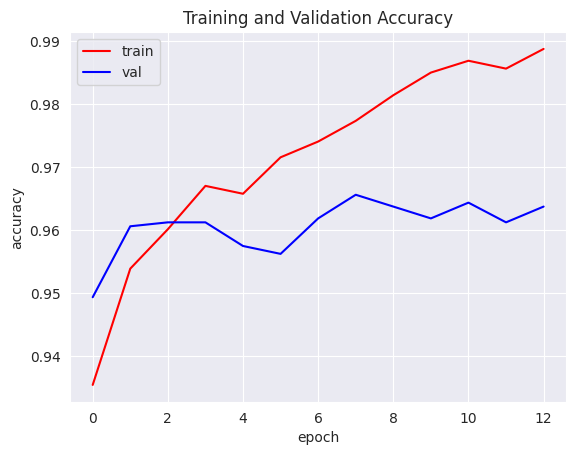

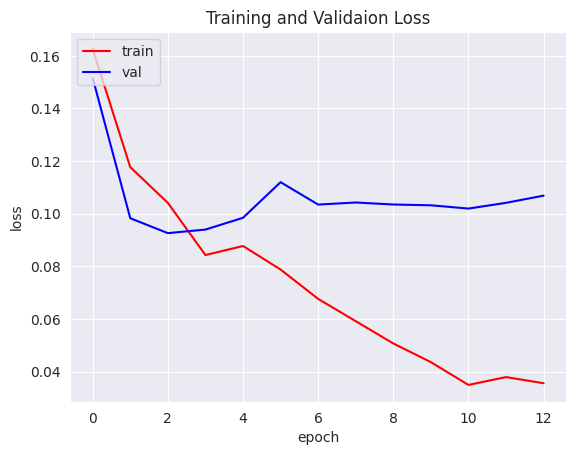

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



              precision    recall  f1-score   support

         Cat     0.9587    0.9663    0.9625      1010
         Dog     0.9654    0.9576    0.9615       990

    accuracy                         0.9620      2000
   macro avg     0.9621    0.9620    0.9620      2000
weighted avg     0.9620    0.9620    0.9620      2000



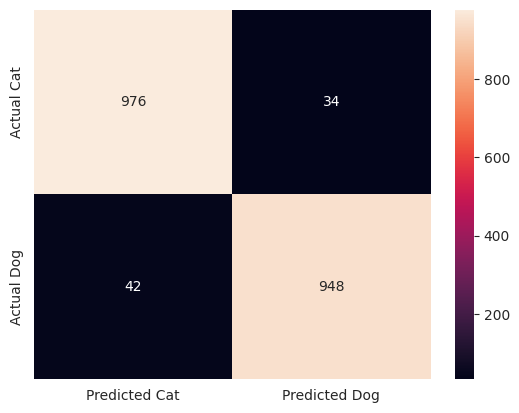

In [27]:
test_generator.reset()

preds_1 = model_1.predict(test_generator,verbose=0)
preds_1 = preds_1.copy()
preds_1[preds_1 <= 0.5] = 0
preds_1[preds_1 > 0.5] = 1

cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1, labels=[0, 1]),index=["Actual Cat", "Actual Dog"],
columns=["Predicted Cat", "Predicted Dog"])
sns.heatmap(cm,annot=True,fmt="d")

print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_1,target_names =['Cat','Dog'], digits=4))

## Konversi Model

In [46]:
export_dir = 'saved_model/'
model_1.export(export_dir)
print(f"✅ Model SavedModel berhasil disimpan di: {export_dir}")

converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

print("✅ Model TF-Lite berhasil disimpan!")

model_1.save("model.h5")
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

print("✅ Model TFJS berhasil disimpan!")

Saved artifact at 'saved_model/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134722157932432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134722157936464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134722157936080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134722477511440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134722477513168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134722157935888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134722155266896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134722155266512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134722157931856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134722155267280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13472215526708

✅ Model TF-Lite berhasil disimpan!
2025-12-02 10:36:09.118931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764671769.145597   29162 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764671769.153424   29162 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764671769.171958   29162 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764671769.172006   29162 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764671769.172010   29162 computation_pl

## Inference (Optional)

In [41]:
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = load_img(path, target_size=(150, 150))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x / 255.0

  images = np.vstack([x])
  classes = model_1.predict(images, batch_size=10)

  print(fn)
  if classes[0] > 0.5:
    print(fn + " is a DOG 🐶")
  else:
    print(fn + " is a CAT 🐱")

Saving images.jpeg to images.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
images.jpeg
images.jpeg is a DOG 🐶
